# Resampling strategies

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F08_ensemble_methods.ipynb)

<div class="alert alert-block alert-warning">
    <b>Prerequisites</b>
    
- Apply ordinary least squares;
- Apply bias-variance decomposition to understand the overfit-underfit tradeoff;
- Test model prediction skills.
</div>

<div class="alert alert-block alert-info">
    <b>Learning Outcomes</b>

- Combining several models together;
- Estimate the expected prediction error using cross-validation
- Understand the difference between cross-validation and bootstrapping.
</div>

In practice, we do not have access to an infinite sample of data to estimate the variance and the bias of model. One need to use part of the data to train the model and part of the data to test it. Two popular approaches are **Cross-Validation** and **Bootstrap**, but are used for different purpuses: Cross-Validation is used to test how well a model perform on unseen data, Bootstrap is used to estimate the uncertainty on the parameters.

## Cross-Validation

- Data is often scarce so that living aside test data to estimate the Prediction Error (PE) is a problem
- *Cross-validation* is used to estimate the Expected PE (EPE), while avoiding living aside test data
- It uses part of the data to train, part of the data to test, repeating the operation on different subset selections

### $K$-Fold Cross Validation

1. Slice the train data into $K$ roughly equal-sized parts;
2. Keep the $K$th part for validation and train on the $K - 1$ other parts;
3. Compute the prediction error $K$ using the $K$th part;
4. Repeat the operation for all $K$ parts;
5. Average the prediction errors to estimate the EPE.

<img src="images/K-fold_cross_validation_EN.svg" width="500">

<div class="alert alert-block alert-warning">
    <b>Warning</b>
    
Cross-validation allows one to estimate **expected** prediction error rather than the prediction error conditioned on a particular training set (see Chap. 7.12 in Hastie *et al.* 2009).
</div>

### Choosing the number $K$ of parts

- **$K$ small** (e.g. $K = 2$):
    <br>biases towards large error (CV training sets size $(K - 1) / K \times N$ much smaller than original training set size $N$);
- **$K$ large** (e.g. $K = N$, leave-one out CV):
    <br>unbiased estimate of EPE, but with high variance ($N$ "training sets" are similar to each other);
- **$K = 5$ or 10**:
    <br>recommended by Hastie *et al.* (2009) as a good compromise, but depends on case study.

### Adapting Cross-Validation to the Data Structure

For instance:
- By choosing the the number of parts $K$ to adapt to cycles (e.g. avoid splitting years)
- By grouping (e.g. if measurements for different people should be kept together)
- Shuffling splits (e.g. if the ordering of the data is special)
- By taking serial correlations into account in time series.

See https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators

## Bootstrapping

- Sample with replacement from original data (same size N)
- Train model on bootstrap sample
- Test on out-of-bag (OOB) samples (not selected)
- Repeat B times (typically 100-1000)
- Analyze distribution of results


## Ensemble methods based on bootstrapping

- With cross-validation and boostrapping (shuffled version), we have resampled the training data to assess the accuracy of a prediction or a parameter estimate.
- *Bagging* (Bootstrap AGGregatING) is the use of bootstrapping to improve the estimate or prediction itself.

### Bagging method

Given training data $\mathbf{Z} = \{(x_1, y_1), \ldots, (x_N, y_N)\}$,

- Get $B$ boostrap samples $\mathbf{Z}^{*b}, b = 1, \ldots, B$;
- Fit a model $\hat{f}^{*b}$ to each bootstrap sample;
- Given a new input $x$, generate predictions $\hat{f}^{*b}(x)$ from each model;
- Average the predictions to get the bagging prediction:

\begin{equation}
\hat{f}_\mathrm{bag}(x) = \frac{1}{B} \sum_{b = 1}^B \hat{f}^{*b}(x).
\end{equation}

### Why bagging?

<div class="alert alert-block alert-info">
   Bagging reduces variance and leaves bias unchanged.
</div>

- The base estimator $\hat{f}$ is too complex and overfits;
- Each bootstrap estimate $\hat{f}^{*b}$ also overfits;
- But averaging them reduces their there variance and thus their tendency to overfit.

### Bagging usage

- For regression / classification;
- The base estimator can be any model;
- But it works especially well for high-variance, low-bias base estimator such as trees;
- The number of models $B$ is a hyperparameter controlling the regularization;
- Drawback: A bagged tree is no longer a tree which limits interpretation.

### Bagging example

#### Generating a synthetic dataset for the sake of the example

First, we will generate a simple synthetic dataset to get insights regarding bootstraping.

In [1]:
# Numerical analysis modules
import numpy as np
import pandas as pd

# Default number of training samples
N = 30
    
# Default noise standard deviation
sigma = 4.

# Initialize random number generator
rng = np.random.RandomState(1)

# Plot configuration
xlabel = 'Input'
ylabel = 'Target'
xlim = 3.5 * np.array([-1, 1])

def f(x):
    noise = sigma * rng.randn(len(x))
    y = x**3 - 0.5 * (x+1)**2 + noise
    y /= y.std()
    
    return y

def generate_data(n_samples=N):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_min, x_max = xlim * 3 / 3.5
    
    # Generate train data
    x_train = rng.uniform(x_min, x_max, size=n_samples)
    y_train = f(x_train)
    input_train = pd.Series(x_train, name=xlabel)
    target_train = pd.DataFrame(y_train, index=x_train, columns=[ylabel])
    target_train.index.name = input_train.name
    
    # Generate test data
    x_test = np.linspace(*xlim, num=300)
    y_test = f(x_test)
    input_test = pd.Series(x_test, name=xlabel)
    target_test = pd.DataFrame(y_test, index=x_test, columns=[ylabel])
    target_test.index.name = input_test.name

    return input_train, input_test, target_train, target_test

<Axes: title={'center': 'Synthetic training dataset'}, xlabel='Input'>

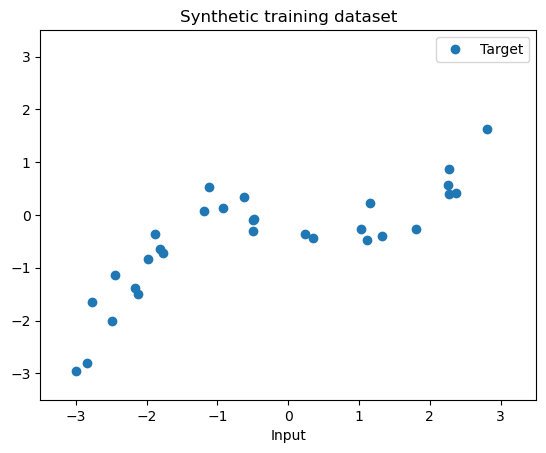

In [2]:
# Plot modules
import matplotlib.pyplot as plt

# Generate training set
input_train, input_test, target_train, target_test = generate_data(n_samples=N)

# Plot training set
ylim = xlim
kwargs_plot_train = dict(xlim=xlim, ylim=ylim)
target_train.plot(style='o',title='Synthetic training dataset', xlim=xlim, ylim=ylim)

#### Individual predictions

The relationship between target and the input is nonlinear.

Let us first see how an individual OLS and an individual decision tree perform.

In [3]:
# Machine-learning modules
from sklearn import linear_model, tree, preprocessing, pipeline, metrics

# Make these estimators available
linear_reg = linear_model.LinearRegression()
spline_reg = pipeline.make_pipeline(
    preprocessing.SplineTransformer(n_knots=4, degree=1), linear_reg)
tree_reg = tree.DecisionTreeRegressor(max_depth=3, random_state=0)
base_estimators = [linear_reg, tree_reg, spline_reg]

def get_individual_prediction(base_estimator=base_estimators[0]):
    # Fit estimator
    X_train = input_train.values[:, None]
    y_train = target_train[ylabel].values
    base_estimator.fit(X_train, y_train)
    
    # Get prediction from test input
    X_test = input_test.values[:, None]
    y_pred = base_estimator.predict(X_test)
    
    # Get test score
    y_test = target_test[ylabel].values
    score_test = base_estimator.score(X_test, y_test)
    
    return y_pred, score_test   
    
def plot_individual_prediction(base_estimator=base_estimators[0]):
    y_pred, score_test = get_individual_prediction(base_estimator)
    target_pred = pd.DataFrame(y_pred, index=input_test, columns=[ylabel])
    
    # Plot
    ax = target_train.plot(style='o', label='Training set', **kwargs_plot_train)
    title = 'R2 = {:.2f}'.format(score_test)
    target_pred.plot(ax=ax, label='Simple prediction',title=title)

In [4]:
from ipywidgets import interact
interact(plot_individual_prediction, base_estimator=[('Linear', base_estimators[0]), 
                                                     ('Tree', base_estimators[1]), 
                                                     ('Spline', base_estimators[2])])

interactive(children=(Dropdown(description='base_estimator', options=(('Linear', LinearRegression()), ('Tree',…

<function __main__.plot_individual_prediction(base_estimator=LinearRegression())>

#### Generating bootstrap samples

- Randomly draw $N$ points from $\mathbf{Z}$ with replacement. To do so:
  - Use a random number generator to draw $N$ integers from $1$ to $N$. The same integer may be drawn multiple times (replacement);
  - Take these integers as indices to select input-output pairs in $\mathbf{Z}$;
- Repeat $B$ times to get $B$ samples $\mathbf{Z}^{*b}$, each containing $N$ points.

Thus, the bootstrap sample will contain some data points several times while some of the original data points will not be present.

However, a smaller number points may be drawn with or without replacement.

This is illustrated below, where the number of points per boostrap sample is `max_samples` and where `replace` controls whether points are replaced or not. 

In [5]:
def get_bootstrap_sample(max_samples=N, replace=True):
    # Get random indices
    bootstrap_indices = rng.choice(N, size=max_samples, replace=replace)
    
    # Generate boostrap sample
    input_b = input_train.iloc[bootstrap_indices]
    target_b = target_train.iloc[bootstrap_indices]
    
    # Get fraction of unique samples
    fraction = len(np.unique(bootstrap_indices)) / N
    
    return input_b, target_b, fraction

def plot_bootstrap_sample(Resample=False, max_samples=N, replace=True):
    input_b, target_b, fraction = get_bootstrap_sample(max_samples, replace)

    ax = target_train.plot(style='o',label='Training set', **kwargs_plot_train)
    title = 'Percentage of unique samples: {}%'.format(int(fraction * 100))
    target_b.Target.rename('Bootstrap sample').plot(ax=ax, title=title, alpha=0.5, style='r.')
    plt.legend()

In [6]:
interact(plot_bootstrap_sample,max_samples=(1,N))

interactive(children=(Checkbox(value=False, description='Resample'), IntSlider(value=30, description='max_samp…

<function __main__.plot_bootstrap_sample(Resample=False, max_samples=30, replace=True)>

- Observe that the variations all share common points with the original dataset.
- The percentage of different training points found in the bootstrap sample is given in the title.
- Some of the points are randomly resampled several times and appear as darker orange circles.

#### Bootstrapping predictions

- Now, we can fit an estimator for each of these datasets and they all shall be slightly different as well.
- We can use each of the estimator to predict on the testing data.
- They shall give slightly different predictions.

In [7]:
# Default number of estimators
N_ESTIMATORS = 5

def get_bootstrap_predictions(
    base_estimator, n_estimators, max_samples, replace):
    # Get bootstrap predictions
    X_test = input_test.values[:, None]
    y_preds = np.empty((n_estimators, X_test.shape[0]))
    for b in range(n_estimators):
        input_b, target_b, _ = get_bootstrap_sample(max_samples, replace)
        X_b = input_b.values[:, None]
        y_b = target_b[ylabel].values
        base_estimator.fit(X_b, y_b)
        y_preds[b] = base_estimator.predict(X_test)
        
    return y_preds

def plot_bootstrap_predictions(Resample=False, base_estimator=linear_reg,
                               n_estimators=N_ESTIMATORS):
    y_preds = get_bootstrap_predictions(base_estimator, n_estimators, N, True)
    
    ax = target_train.plot(style='o', label='Training set', **kwargs_plot_train)
    for b in range(n_estimators):
        target_pred_b = pd.DataFrame(
            y_preds[b], index=input_test, columns=[ylabel])
        label = 'Bootstrap prediction {}'.format(b)
        target_pred_b.Target.rename(label).plot(ax=ax,style='--')
    plt.legend()

In [8]:
interact(plot_bootstrap_predictions, base_estimator=[('Linear', base_estimators[0]), 
                                                     ('Tree', base_estimators[1]), 
                                                     ('Spline', base_estimators[2])], 
             n_estimators=(1,N_ESTIMATORS,1))

interactive(children=(Checkbox(value=False, description='Resample'), Dropdown(description='base_estimator', op…

<function __main__.plot_bootstrap_predictions(Resample=False, base_estimator=LinearRegression(), n_estimators=5)>

#### Aggregating

- Once our $B$ estimators are fitted and we are able to get $B$ predictions, one for each.
- In regression, the most straightforward way to combine those predictions is just to average them.

We can plot the averaged predictions from the previous example.

In [9]:
def plot_bagging(Resample=False, base_estimator=linear_reg, n_estimators=N_ESTIMATORS,
                 plot_bootstrap_predictions=True):
    y_preds = get_bootstrap_predictions(base_estimator, n_estimators, N, True)
    
    # Get bagged prediction
    y_pred_bag = y_preds.mean(0)
    target_pred_bag = pd.DataFrame(
        y_pred_bag, index=input_test, columns=[ylabel])
    
    # Get test score
    y_test = target_test[ylabel].values
    score_test = metrics.r2_score(y_test, y_pred_bag)
    
    ax = target_train.plot(style='o',label='Training set', **kwargs_plot_train)
    title = 'R2(bagging) = {:.2f}'.format(score_test)
    target_pred_bag.plot(ax=ax, label='Bagging prediction',
                                title=title)
    
    # Add bootstrap predictions
    if plot_bootstrap_predictions:
        for b in range(n_estimators):
            target_pred_b = pd.DataFrame(
                y_preds[b], index=input_test, columns=[ylabel])
            label = 'Bootstrap prediction {}'.format(b)
            target_pred_b.Target.rename(label).plot(ax=ax, style='--')
        plt.legend()

In [10]:
interact(plot_bagging, base_estimator=[('Linear', base_estimators[0]), 
                                        ('Tree', base_estimators[1]), 
                                        ('Spline', base_estimators[2])], 
             n_estimators=(1,N_ESTIMATORS,1))

interactive(children=(Checkbox(value=False, description='Resample'), Dropdown(description='base_estimator', op…

<function __main__.plot_bagging(Resample=False, base_estimator=LinearRegression(), n_estimators=5, plot_bootstrap_predictions=True)>

- The blue line shows the averaged predictions, which would be the final predictions given by our "bag" of regressors.
- Note that the predictions of the ensemble is more stable because of the averaging operation.
- As a result, the bag of estimators as a whole is less likely to overfit than the individual trees.

#### Boostrap estimates

As with cross-validation, we can directly plot the distribution of parameter estimates from the bootstrap estimators to evaluate the variability of the estimates.

In [11]:
# Boostrap configuration with spline base estimators
base_estimator = spline_reg
n_estimators = N_ESTIMATORS
max_samples = N
replace = True

# Get bootstrap estimates
X_test = input_test.values[:, None]
coefs = []
b = 0
while b < n_estimators:
    input_b, target_b, _ = get_bootstrap_sample(max_samples, replace)
    X_b = input_b.values[:, None]
    y_b = target_b[ylabel].values
    base_estimator.fit(X_b, y_b)
    coef = base_estimator[1].coef_
    if (np.abs(coef) < 1.e10).all():
        coefs.append(coef.copy())
        b += 1

df_coefs = pd.DataFrame(coefs)
df_coefs.index.name = 'Spline'
df_coefs.index.name = 'Coefficients'

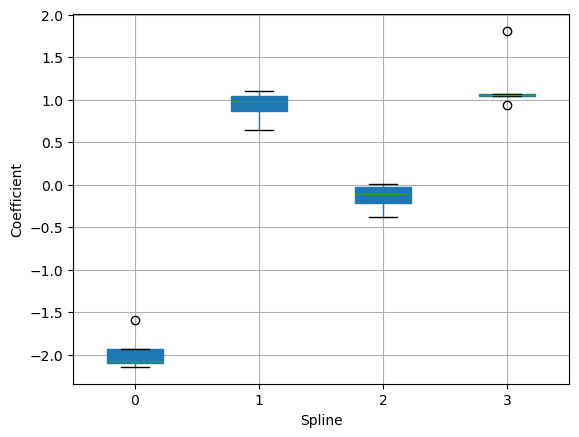

In [12]:
df_coefs.boxplot(xlabel='Spline', ylabel='Coefficient',patch_artist=True)
plt.title=('Coefficient importance and variability')

Possible Pull Request: update the plot to show the uncertainty on OLS coefs.

## To go further

- [Bootstrapping features with Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html);
- [Feature importances in Scikit-learn course](https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html#randomforest-feature-importances);
- Bayesian models (Bishop 2006);
- Relationship between bootstrap, maximum likelihood and Bayesian methods (Chap. 8 in Hastie *et al.* 2009);
- More on boosting methods and analytical results (Chap. 10 in Hastie *et al.* 2009);
- Versions of ensemble methods for classification (Hastie *et al.* 2009).

## References

- Chap. 8-10, 15 and 16 in [Hastie, T., Tibshirani, R., Friedman, J., 2009. *The Elements of Statistical Learning*, 2nd ed. Springer, New York.](https://doi.org/10.1007/978-0-387-84858-7)
- [Bishop, C., 2006. Pattern Recognition and Machine Learning, Information Science and Statistics. Springer-Verlag, New York.](https://www.cs.uoi.gr/~arly/courses/ml/tmp/Bishop_book.pdf)
- [Du, P., 2019. Ensemble Machine Learning-Based Wind Forecasting to Combine NWP Output With Data From Weather Station. *IEEE Transactions on Sustainable Energy* 10, 2133-2141.](https://doi.org/10/gnbgvj)

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>